## Задача

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pathlib

%matplotlib inline
%precision %.4f
warnings.filterwarnings('ignore') 

# Стоимость жилья
Подробное описание датасета: https://www.kaggle.com/datasets/anmolkumar/house-price-prediction-challenge?datasetId=902117

На этих данных предлагается решить задачу регрессии: предсказать стоимость жилья

In [2]:
data = pd.read_csv(pathlib.Path("train.csv"), encoding='unicode_escape')
data.shape

(29451, 12)

In [3]:
data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [4]:
data.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


# EDA

Датасет не содержит нулевых значений, однако содержит дублирующиеся записи - удалим их

In [5]:
data.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [6]:
data.duplicated().sum()

401

In [7]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Переведем категориальные признаки в числовые

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(data.POSTED_BY.drop_duplicates()) 
data.POSTED_BY = encoder.transform(data.POSTED_BY)

encoder.fit(data.BHK_OR_RK.drop_duplicates()) 
data.BHK_OR_RK = encoder.transform(data.BHK_OR_RK)

Ранжируем города в соответствии с https://en.wikipedia.org/wiki/Classification_of_Indian_cities

In [9]:
data["ADDRESS"] = data["ADDRESS"].str.split(',').apply(lambda x: x[-1])
data["ADDRESS"].value_counts(ascending=False).head(25)

Bangalore        4272
Lalitpur         2963
Mumbai           2006
Pune             1980
Noida            1718
Kolkata          1686
Maharashtra      1571
Chennai          1245
Ghaziabad        1070
Jaipur            950
Chandigarh        660
Faridabad         625
Mohali            533
Vadodara          509
Gurgaon           419
Surat             419
Nagpur            331
Lucknow           321
Indore            301
Bhubaneswar       231
Bhopal            217
Kochi             205
Visakhapatnam     178
Bhiwadi           160
Goa               149
Name: ADDRESS, dtype: int64

In [10]:
def map_city(city):
    if city in ['Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune', 'Maharashtra']:
        return 1
    elif city in ['Agra', 'Ajmer', 'Aligarh', 'Amravati', 'Amritsar', 'Asansol', 'Aurangabad', 'Bareilly', 
                  'Belgaum', 'Bhavnagar', 'Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bikaner', 'Bilaspur', 'Bokaro Steel City', 
                  'Chandigarh', 'Coimbatore', 'Cuttack', 'Dehradun', 'Dhanbad', 'Bhilai', 'Durgapur', 'Dindigul', 'Erode', 
                  'Faridabad', 'Firozabad', 'Ghaziabad', 'Gorakhpur', 'Gulbarga', 'Guntur', 'Gwalior', 'Gurgaon', 'Guwahati', 
                  'Hamirpur', 'Hubli–Dharwad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 
                  'Jhansi', 'Jodhpur', 'Kakinada', 'Kannur', 'Kanpur', 'Karnal', 'Kochi', 'Kolhapur', 'Kollam', 'Kozhikode', 
                  'Kurnool', 'Ludhiana', 'Lucknow', 'Madurai', 'Malappuram', 'Mathura', 'Mangalore', 'Meerut', 'Moradabad', 
                  'Mysore', 'Nagpur', 'Nanded', 'Nashik', 'Nellore', 'Noida', 'Patna', 'Pondicherry', 'Purulia', 'Prayagraj', 
                  'Raipur', 'Rajkot', 'Rajahmundry', 'Ranchi', 'Rourkela', 'Ratlam', 'Salem', 'Sangli', 'Shimla', 'Siliguri', 
                  'Solapur', 'Srinagar', 'Surat', 'Thanjavur', 'Thiruvananthapuram', 'Thrissur', 'Tiruchirappalli', 'Tirunelveli', 
                  'Tiruvannamalai', 'Ujjain', 'Bijapur', 'Vadodara', 'Varanasi', 'Vasai-Virar City', 'Vijayawada', 'Visakhapatnam', 
                  'Vellore', 'Warangal']:
        return 2
    else:
        return 3
    
data['TIER'] = data['ADDRESS'].apply(map_city)
data = data.drop(columns = 'ADDRESS')

In [11]:
data["TARGET"] = data["TARGET(PRICE_IN_LACS)"]
data = data.drop(columns="TARGET(PRICE_IN_LACS)")
data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TIER,TARGET
0,2,0,0,2,0,1300.236407,1,1,12.969910,77.597960,1,55.0
1,1,0,0,2,0,1275.000000,1,1,12.274538,76.644605,2,51.0
2,2,0,0,2,0,933.159722,1,1,12.778033,77.632191,1,43.0
3,2,0,1,2,0,929.921143,1,1,28.642300,77.344500,2,62.5
4,1,1,0,2,0,999.009247,0,1,22.592200,88.484911,1,60.5


На диаграмме видно, что READY_TO_MOVE и RERA совпадают, также почти совпадают BHK_NO. и SQUARE_FT.

<AxesSubplot: >

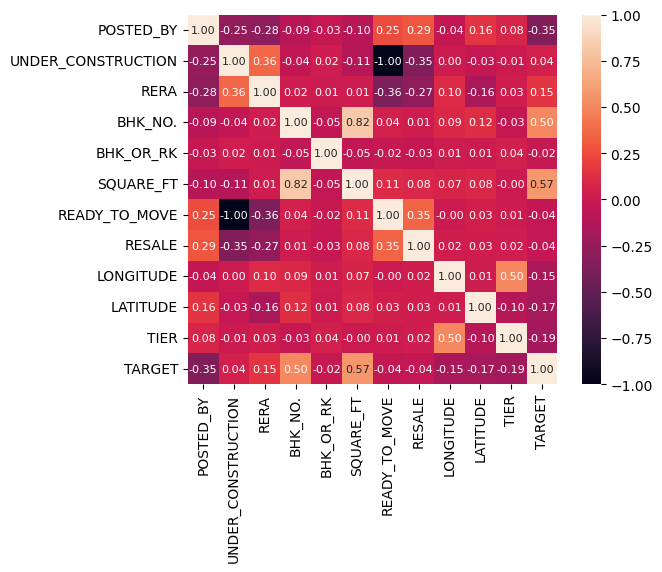

In [12]:
sns.heatmap(
    data.corr(method='spearman'),
    cbar=True,
    square=True,
    fmt='.2f',
    annot=True,
    annot_kws={'size':8},
)

In [13]:
data = data.drop(columns=["READY_TO_MOVE", "RERA"])

<AxesSubplot: >

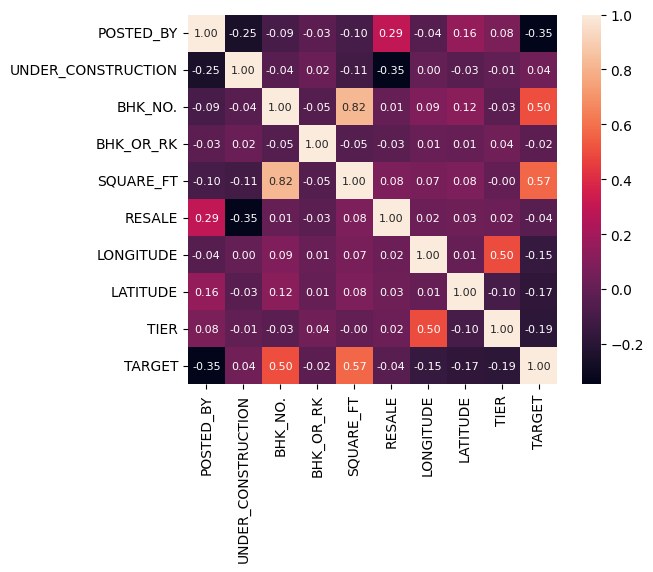

In [14]:
sns.heatmap(
    data.corr(method='spearman'),
    cbar=True,
    square=True,
    fmt='.2f',
    annot=True,
    annot_kws={'size':8},
)

# Инофрмация о системе

In [15]:
!echo "-- CPU --"
!lscpu | grep name
!echo "-- RAM --"
!free -g -h -t | grep Mem | cut -c1-23
!echo "-- OS --"
!uname --kernel-release
!echo "-- Python --"
!python --version

-- CPU --
Model name:                      Intel(R) Core(TM) i5-10600KF CPU @ 4.10GHz
-- RAM --
Mem:            15Gi   
-- OS --
5.4.236-1-MANJARO
-- Python --
Python 3.10.9


# Мои реализации

In [16]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator


class AnsambleRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_estimator_(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor() 

    def _set_random_states(self, estimator):
        states = {}
        for param in estimator.get_params(deep=True):
            if param == "random_state" or param.endswith("__random_state"):
                states[param] = self.random_state_.tomaxint() % 2 ** 32
        return states

    def _choose_data(self, X, y):
        indices = self.random_state_.choice(len(y), size=len(y))
        return X[indices], y[indices]
    
    def _new_estimator(self):
        estimator = clone(self.estimator_)
        estimator.set_params(**self._set_random_states(estimator))
        return estimator


class MyBaggingRegressor(AnsambleRegressor):


    def fit(self, X, y):
        self._set_estimator_()
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.n_features_in_ = X.shape[1]
        self.estimators_ = []

        for i in range(self.n_estimators):
            estimator = self._new_estimator()
            X_sample, y_sample = self._choose_data(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = [estimator.predict(X) for estimator in self.estimators_]

        return np.mean(predictions, axis=0)


class MyAdaBoostRegressor(AnsambleRegressor):

    def fit(self, X, y):
        self._set_estimator_()
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, y_numeric=True)
    
        self.n_features_in_ = X.shape[1]
        self.estimators_ = []
        self.weights_ = []

        sample_weight = np.full(len(y), fill_value=(1 / len(y)))

        for _ in range(self.n_estimators):
            estimator = self._new_estimator()
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)

            errors = np.abs(predicted - y)
            max_error = np.max(errors)
            if max_error > 0:
                errors /= max_error
            avg_error = np.sum(errors * sample_weight)

            match avg_error:
                case 0: 
                    self.estimators_.append(estimator)
                    self.weights_.append(1.0)
                case x if x >= 0.5 and len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.weights_.append(1.0)
                case _:
                    beta = avg_error / (1 - avg_error)
                    sample_weight *= np.power(beta, 1 - errors)
                    sample_weight /= np.sum(sample_weight)

                    self.estimators_.append(estimator)
                    self.weights_.append(np.log(1 / beta))

        self.weights_ = np.array(self.weights_)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.weights_[sorted_prediction_ids], axis=1)
        is_median_or_above = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)

        median_ids = np.argmax(is_median_or_above, axis=1)
        median_ids = sorted_prediction_ids[np.arange(len(X)), median_ids]

        return predictions[np.arange(len(X)), median_ids]

check_estimator(MyBaggingRegressor())
check_estimator(MyAdaBoostRegressor())

# Обучение

In [17]:
X, Y = data.drop(columns="TARGET"), data.TARGET

In [18]:
MAGIC_NUMBER = 106 # used for random states
BRUTE_FORCE = 1000

In [37]:
import optuna
import os
import gc
from sklearn.model_selection import cross_validate, KFold


def fit(estimator, params_distribution):
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(BRUTE_FORCE), 
        direction="maximize",
    )

    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        params_distribution,
        scoring="r2",
        n_jobs=3,
        n_trials=None,
        random_state=MAGIC_NUMBER,
        study=study,
    )

    results = cross_validate(
        search_model,
        X,
        Y,
        cv=KFold(shuffle=True, random_state=MAGIC_NUMBER),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=2,
    )


    return results


def add_to_comparsion(model_name, fitting_results, csv_path):
    results = pd.DataFrame(fitting_results).rename(
        columns={
            "estimator": "Model", 
            "fit_time": "Fit time, s", 
            "score_time": "Score time, s", 
            "test_r2": "R2"
        }
    )

    results["Model"] = model_name
    results["MAE"] = -results["test_neg_mean_absolute_error"]
    results = results.drop(columns=["test_neg_mean_absolute_error"])
    results.to_csv(csv_path, mode="a", header=not csv_path.exists())


def add_model(name, estimator, params_distribution, models):
    models.append((name, fit(estimator, params_distribution)))


def add_all_to_comparsion(fitting_results, csv_path):
    if os.path.exists(csv_path):
      os.remove(csv_path)
    for (name, fitting_result) in fitting_results:
        add_to_comparsion(name, fitting_result, csv_path)


def show_comparsion(csv_path):
    cv_results = pd.read_csv(csv_path)

    img, axs = plt.subplots(ncols=4, figsize=(15, 4))

    for y, ax in zip(["Fit time, s", "Score time, s", "R2", "MAE"], axs.flatten()):
        sns.barplot(cv_results[["Model", y]], x="Model", y=y, errwidth=1, capsize=0.3, ax=ax)
        ax.tick_params(axis="x", rotation=90)
        ax.set_xlabel(None)

    img.tight_layout()

    plt.show()

# Boosting

Здесь и далее параметры будут прокомментированы в следующем виде

`(на что влияет)[к чему может "привести"]`

Подразумевается прямая корреляция если не указано иное

In [38]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
boosting_models = []

In [39]:
add_model(
    "GradientBoosting",
    GradientBoostingRegressor(random_state=MAGIC_NUMBER),
    {
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        # (количество корректируемых ошибок (на шаге)) [переобучение ансамбля]
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        # (глубина деревьев) [переобучение "хороших" деревьев]
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
    boosting_models
)


[I 2023-04-01 18:12:24,498] Trial 2 finished with value: 0.8931705400482356 and parameters: {'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.8931705400482356.
[I 2023-04-01 18:12:24,528] Trial 2 finished with value: 0.8905067170382548 and parameters: {'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.8905067170382548.
[I 2023-04-01 18:12:27,234] Trial 1 finished with value: 0.890322897421908 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': None}. Best is trial 2 with value: 0.8905067170382548.
[I 2023-04-01 18:12:27,237] Trial 1 finished with value: 0.892501905913951 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': None}. Best is trial 2 with value: 0.8931705400482356.
[I 2023-04-01 18:12:32,606] Trial 0 finished with value: 0.892013822933262 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is tr

[I 2023-04-01 18:13:32,624] Trial 20 finished with value: 0.8892240454794441 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.892013822933262.
[I 2023-04-01 18:13:32,770] Trial 20 finished with value: 0.8929364293990517 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 10}. Best is trial 17 with value: 0.896767507379829.
[I 2023-04-01 18:13:35,039] Trial 21 finished with value: 0.8929364293990517 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 1000}. Best is trial 17 with value: 0.896767507379829.
[I 2023-04-01 18:13:35,206] Trial 21 finished with value: 0.8892240454794441 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 1000}. Best is trial 0 with value: 0.892013822933262.
[I 2023-04-01 18:13:43,371] Trial 19 finished with value: 0.8947929509721873 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': None}.

[I 2023-04-01 18:14:47,043] Trial 1 finished with value: 0.8760269116678657 and parameters: {'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': None}. Best is trial 1 with value: 0.8760269116678657.
[I 2023-04-01 18:14:49,713] Trial 0 finished with value: 0.8950602298736767 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.8950602298736767.
[I 2023-04-01 18:14:52,442] Trial 0 finished with value: 0.8776861812309198 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is trial 0 with value: 0.8776861812309198.
[I 2023-04-01 18:14:55,306] Trial 4 finished with value: 0.8900236793686862 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': None}. Best is trial 0 with value: 0.8950602298736767.
[I 2023-04-01 18:14:57,999] Trial 4 finished with value: 0.8758097032680536 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': None}. Best 

[I 2023-04-01 18:15:52,671] Trial 20 finished with value: 0.874586792903937 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 10}. Best is trial 17 with value: 0.8823095974921623.
[I 2023-04-01 18:15:55,164] Trial 21 finished with value: 0.874586792903937 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 1000}. Best is trial 17 with value: 0.8823095974921623.
[I 2023-04-01 18:16:00,570] Trial 19 finished with value: 0.8946011060993829 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': None}. Best is trial 5 with value: 0.8983498629688986.
[I 2023-04-01 18:16:00,809] Trial 22 finished with value: 0.8947601207060811 and parameters: {'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': None}. Best is trial 5 with value: 0.8983498629688986.
[I 2023-04-01 18:16:03,120] Trial 19 finished with value: 0.8786087741348328 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': Non

[I 2023-04-01 18:17:23,025] Trial 3 finished with value: 0.8660800484193883 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 1000}. Best is trial 1 with value: 0.8682013371601436.
[I 2023-04-01 18:17:25,504] Trial 6 finished with value: 0.8660587500261157 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': None}. Best is trial 1 with value: 0.8682013371601436.
[I 2023-04-01 18:17:28,222] Trial 8 finished with value: 0.8637690614003875 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.8682013371601436.
[I 2023-04-01 18:17:30,500] Trial 7 finished with value: 0.8663833002180115 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 1000}. Best is trial 1 with value: 0.8682013371601436.
[I 2023-04-01 18:17:30,699] Trial 9 finished with value: 0.853644675134887 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 1000}. Best

In [45]:
add_model(
    "AdaBoost",
    AdaBoostRegressor(random_state=MAGIC_NUMBER),
    {
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        # (количество корректируемых ошибок (на шаге)) [переобучение ансамбля]
        "learning_rate": optuna.distributions.CategoricalDistribution([0.5, 1, 2]),
    },
    boosting_models
)

[I 2023-04-01 18:29:02,296] Trial 2 finished with value: -0.3307721568568642 and parameters: {'n_estimators': 50, 'learning_rate': 2}. Best is trial 2 with value: -0.3307721568568642.
[I 2023-04-01 18:29:02,830] Trial 0 finished with value: 0.792617575240083 and parameters: {'n_estimators': 200, 'learning_rate': 1}. Best is trial 0 with value: 0.792617575240083.
[I 2023-04-01 18:29:03,086] Trial 3 finished with value: -0.3307721568568642 and parameters: {'n_estimators': 400, 'learning_rate': 2}. Best is trial 0 with value: 0.792617575240083.
[I 2023-04-01 18:29:03,565] Trial 2 finished with value: -0.47135843897932217 and parameters: {'n_estimators': 50, 'learning_rate': 2}. Best is trial 2 with value: -0.47135843897932217.
[I 2023-04-01 18:29:03,890] Trial 5 finished with value: -0.3307721568568642 and parameters: {'n_estimators': 200, 'learning_rate': 2}. Best is trial 0 with value: 0.792617575240083.
[I 2023-04-01 18:29:04,315] Trial 0 finished with value: 0.5764267485436274 and par

[I 2023-04-01 18:29:17,772] Trial 8 finished with value: 0.6862891837821101 and parameters: {'n_estimators': 50, 'learning_rate': 1}. Best is trial 1 with value: 0.8429310347269375.
[I 2023-04-01 18:29:18,977] Trial 11 finished with value: 0.6366193837566647 and parameters: {'n_estimators': 400, 'learning_rate': 1}. Best is trial 9 with value: 0.8215875744447668.
[I 2023-04-01 18:29:19,008] Trial 9 finished with value: 0.8429310347269375 and parameters: {'n_estimators': 50, 'learning_rate': 0.5}. Best is trial 1 with value: 0.8429310347269375.
[I 2023-04-01 18:29:19,128] Trial 10 finished with value: 0.7995675450188704 and parameters: {'n_estimators': 400, 'learning_rate': 0.5}. Best is trial 9 with value: 0.8215875744447668.
[I 2023-04-01 18:29:19,458] Trial 11 finished with value: 0.6587820718058071 and parameters: {'n_estimators': 400, 'learning_rate': 1}. Best is trial 1 with value: 0.8429310347269375.
[I 2023-04-01 18:29:19,465] Trial 10 finished with value: 0.8429310347269375 and

In [46]:
add_model(
    "MyAdaBoost",
    MyAdaBoostRegressor(random_state=MAGIC_NUMBER),
    {
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
    },
    boosting_models
)

[I 2023-04-01 18:29:46,329] Trial 2 finished with value: 0.8669069281093863 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.8669069281093863.
[I 2023-04-01 18:29:46,703] Trial 2 finished with value: 0.872934382267942 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.872934382267942.
[I 2023-04-01 18:30:04,429] Trial 1 finished with value: 0.8669069281093863 and parameters: {'n_estimators': 100}. Best is trial 2 with value: 0.8669069281093863.
[I 2023-04-01 18:30:04,893] Trial 1 finished with value: 0.872934382267942 and parameters: {'n_estimators': 100}. Best is trial 2 with value: 0.872934382267942.
[I 2023-04-01 18:30:39,315] Trial 0 finished with value: 0.8669069281093863 and parameters: {'n_estimators': 200}. Best is trial 2 with value: 0.8669069281093863.
[I 2023-04-01 18:30:40,390] Trial 0 finished with value: 0.872934382267942 and parameters: {'n_estimators': 200}. Best is trial 2 with value: 0.872934382267942.
[I 2023-04-01 18:32:03,699] Tr

In [47]:
add_model(
    "HistGradientBoosting",
    HistGradientBoostingRegressor(random_state=MAGIC_NUMBER),
    {
        # (количество корректируемых ошибок (на шаге)) [переобучение ансамбля]
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        # (глубина деревьев) [переобучение "хороших" деревьев]
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([15, 31, 60, None]),
    },
    boosting_models
)

[I 2023-04-01 18:37:37,029] Trial 1 finished with value: 0.7896946749051026 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 1 with value: 0.7896946749051026.
[I 2023-04-01 18:37:38,735] Trial 1 finished with value: 0.8204569466456169 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 1 with value: 0.8204569466456169.
[I 2023-04-01 18:37:40,083] Trial 3 finished with value: 0.798318582459348 and parameters: {'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 3 with value: 0.798318582459348.
[I 2023-04-01 18:37:40,645] Trial 2 finished with value: 0.7809770732341426 and parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 3 with value: 0.798318582459348.
[I 2023-04-01 18:37:41,611] Trial 4 finished with value: 0.7987271165303765 and parameters: {'learning_rate': 0.3, 'max_leaf_nodes': 15}. Best is trial 4 with value: 0.7987271165303765.
[I 2023-04-01 18:37:42,404] Trial 3 finished with value: 0.8245374739935

[I 2023-04-01 18:40:29,491] Trial 6 finished with value: 0.7976557309575354 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': None}. Best is trial 1 with value: 0.7991385037795384.
[I 2023-04-01 18:40:30,922] Trial 10 finished with value: 0.8114017748626863 and parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 15}. Best is trial 7 with value: 0.8168488617384766.
[I 2023-04-01 18:40:35,198] Trial 9 finished with value: 0.7950423288366275 and parameters: {'learning_rate': 0.05, 'max_leaf_nodes': None}. Best is trial 1 with value: 0.7991385037795384.
[I 2023-04-01 18:40:38,259] Trial 11 finished with value: 0.8108579928676752 and parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 31}. Best is trial 7 with value: 0.8168488617384766.
[I 2023-04-01 18:40:44,511] Trial 1 finished with value: 0.8101157895793396 and parameters: {'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 1 with value: 0.8101157895793396.
[I 2023-04-01 18:40:47,773] Trial 3 finished with value: 0.81

In [48]:
add_model(
    "LGBMRegressor",
    LGBMRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        # (количество корректируемых ошибок (на шаге)) [переобучение ансамбля]
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 150]),
        # (глубина деревьев) [переобучение "хороших" деревьев]
        "num_leaves": optuna.distributions.CategoricalDistribution([15, 31, 60]),
    },
    boosting_models
)

[I 2023-04-01 18:41:35,156] Trial 0 finished with value: 0.7762214293908147 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 0 with value: 0.7762214293908147.
[I 2023-04-01 18:41:35,178] Trial 0 finished with value: 0.762460479188747 and parameters: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 15}. Best is trial 0 with value: 0.762460479188747.
[I 2023-04-01 18:41:35,419] Trial 3 finished with value: 0.7932911340526289 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 3 with value: 0.7932911340526289.
[I 2023-04-01 18:41:35,439] Trial 3 finished with value: 0.7896516417739041 and parameters: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 3 with value: 0.7896516417739041.
[I 2023-04-01 18:41:35,639] Trial 2 finished with value: 0.8119961959568418 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 2 with value: 0.811996

[I 2023-04-01 18:41:39,864] Trial 20 finished with value: 0.8057051614073455 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 8 with value: 0.8141701384733269.
[I 2023-04-01 18:41:39,892] Trial 20 finished with value: 0.8059481379483401 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 2 with value: 0.8119961959568418.
[I 2023-04-01 18:41:39,961] Trial 21 finished with value: 0.8134945328461048 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 8 with value: 0.8141701384733269.
[I 2023-04-01 18:41:40,010] Trial 21 finished with value: 0.8109770885715468 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 60}. Best is trial 2 with value: 0.8119961959568418.
[I 2023-04-01 18:41:40,092] Trial 18 finished with value: 0.749615549050052 and parameters: {'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 60}. Best is trial 8 with value: 0.8

[I 2023-04-01 18:41:44,200] Trial 10 finished with value: 0.7917259065599731 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 11 with value: 0.8016137344079178.
[I 2023-04-01 18:41:44,374] Trial 12 finished with value: 0.8019916198536933 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 12 with value: 0.8019916198536933.
[I 2023-04-01 18:41:44,491] Trial 10 finished with value: 0.8137326336854878 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 9 with value: 0.818430377203209.
[I 2023-04-01 18:41:44,545] Trial 12 finished with value: 0.8181129349417713 and parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}. Best is trial 9 with value: 0.818430377203209.
[I 2023-04-01 18:41:44,850] Trial 14 finished with value: 0.8041514069741522 and parameters: {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 14 with val

[I 2023-04-01 18:41:49,045] Trial 8 finished with value: 0.8213091005129156 and parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}. Best is trial 8 with value: 0.8213091005129156.
[I 2023-04-01 18:41:49,232] Trial 7 finished with value: 0.8148029064317261 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 60}. Best is trial 8 with value: 0.8213091005129156.
[I 2023-04-01 18:41:49,298] Trial 9 finished with value: 0.8102065052274142 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}. Best is trial 8 with value: 0.8213091005129156.
[I 2023-04-01 18:41:49,422] Trial 11 finished with value: 0.8235316251312821 and parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15}. Best is trial 11 with value: 0.8235316251312821.
[I 2023-04-01 18:41:49,693] Trial 10 finished with value: 0.8052762666536608 and parameters: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 31}. Best is trial 11 with value: 0.

In [64]:
# Виснет без каких-либо логов
add_model(
    "CatBoost",
    CatBoostRegressor(thread_count=2, random_state=MAGIC_NUMBER),
    {
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([250, 500, 1000]),
    },
    boosting_models
)


KeyboardInterrupt: 

In [51]:
add_model(
    "XGB",
    XGBRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        # (алгоритм построения деревьев)
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        # (количество шагов корректировки) [переобучение ансамбля]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),
        # (количество корректируемых ошибок (на шаге)) [переобучение ансамбля]
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3]),
        # (глубина деревьев) [переобучение "хороших" деревьев]
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([5, 31, 60]),
    },
    boosting_models
)

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:49:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[18:50:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:05,516] Trial 5 finished with value: 0.829864247299956 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 5}. Best is trial 2 with value: 0.8963649922873372.
[18:50:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:05,579] Trial 5 finished with value: 0.846552984647493 and parameters: {'tree_method': 'hist', 'n_estimators

[18:50:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:11,361] Trial 12 finished with value: 0.8363369212462521 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 2 with value: 0.8963649922873372.
[18:50:11] WARNING: ../src/learn

[18:50:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:18,945] Trial 17 finished with value: 0.8947130631556401 and parameters: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.8947130631556401.
[18:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:19,193] Trial 17 finished with value: 0.8958786331992294 and parameters: {'tree_method': 'exact', 'n_est

[18:50:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:27,875] Trial 23 finished with value: 0.8963649922873372 and parameters: {'tree_method': 'exact', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 19 with value: 0.8970956190765842.
[18:50:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:28,269] Trial 23 finished with value: 0.8918508502624061 and parameters: {'tree_method': 'exact', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 20 with value: 0.8948327216000902.
[18:50:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" }

[18:50:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:33,101] Trial 29 finished with value: 0.8490417273355899 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 31}. Best is trial 19 with value: 0.8970956190765842.
[18:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:33,230] Trial 29 finished with value: 0.832526616525542 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 31}. Best is trial 20 with value: 0.8948327216000902.
[18:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } 

[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:38,738] Trial 35 finished with value: 0.829864247299956 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 19 with value: 0.8970956190765842.
[I 2023-04-01 18:50:38,740] Trial 34 finished with value: 0.829864247299956 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 19 with value: 0.8970956190765842.
[18:50:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } a

[18:50:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:47,221] Trial 40 finished with value: 0.8380595546540652 and parameters: {'tree_method': 'approx', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 19 with value: 0.8970956190765842.
[18:50:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:47,402] Trial 40 finished with value: 0.8430493648519833 and parameters: {'tree_method': 'approx', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 18 with value: 0.8950351487234963.
[18:50:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_no

[18:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:51,959] Trial 48 finished with value: 0.8490417273355899 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 19 with value: 0.8970956190765842.
[18:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:52,052] Trial 48 finished with value: 0.832526616525542 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 18 with value: 0.8950351487234963.
[18:50:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" 

[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:55,670] Trial 52 finished with value: 0.8492956213291187 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 19 with value: 0.8970956190765842.
[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:50:55,936] Trial 52 finished with value: 0.8465796799906059 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 18 with value: 0.8950351487234963.
[18:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_node

[18:51:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:03] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:05,501] Trial 59 finished with value: 0.8958786331992294 and parameters: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 56 with value: 0.8975538208405457.
[18:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:05,712] Trial 59 finished with value: 0.8947130631556401 and parameters: {'tree_method': 'exact', 'n_es

[I 2023-04-01 18:51:31,999] Trial 65 finished with value: 0.8953765323994807 and parameters: {'tree_method': 'exact', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 65 with value: 0.8953765323994807.
[18:51:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:32] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:34] WARNING: ../src/lear

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:42] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:42,692] Trial 72 finished with value: 0.8405381684724716 and parameters: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_n

[I 2023-04-01 18:51:45,542] Trial 76 finished with value: 0.8484797773628105 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 65 with value: 0.8953765323994807.
[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:45,686] Trial 77 finished with value: 0.853040860912715 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 65 with value: 0.8977345263598633.
[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[18:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:49,643] Trial 82 finished with value: 0.8465796799906059 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 65 with value: 0.8953765323994807.
[18:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:50,520] Trial 83 finished with value: 0.8492956213291187 and parameters: {'tree_method': 'hist', 'n_esti

[I 2023-04-01 18:51:56,962] Trial 90 finished with value: 0.843772779951639 and parameters: {'tree_method': 'approx', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 65 with value: 0.8977345263598633.
[18:51:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:51:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:51:57,350] Trial 89 finished with value: 0.8481885106292841 and parameters: {'tree_method': 'approx', 'n_

[I 2023-04-01 18:52:00,122] Trial 94 finished with value: 0.8484797773628105 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 65 with value: 0.8953765323994807.
[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:00,672] Trial 95 finished with value: 0.8484797773628105 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 65 with value: 0.

[18:52:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:22,064] Trial 101 finished with value: 0.897670409068726 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 65 with value: 0.8977345263598633.
[18:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:22,086] Trial 100 finished with value: 0.897670409068726 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 65 with value: 0.8977345263598633.
[18:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:22,648] Trial 101 finished with value: 0.8945698025787149 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.1, 'max

[18:52:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:42,615] Trial 107 finished with value: 0.8977345263598633 and parameters: {'tree_method': 'exact', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 65 with value: 0.8977345263598633.
[I 2023-04-01 18:52:42,745] Trial 107 finished with value: 0.8953765323994807 and parameters: {'tree_method': 'exact', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 65 with value: 0.8953765323994807.
[18:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_node

[18:52:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[I 2023-04-01 18:52:53,838] Trial 9 finished with value: 0.7977289372246251 and parameters: {'tree_method': 'hist', 'n_estimators': 400, 'learning_rate': 0.3, 'max_leaf_nodes': 31}. Best is trial 2 with value: 0.8766856354804429.
[18:52:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:52:54,225] Trial 12 finished with value: 0.757204126705707 and parameters: {'tree_method': 'approx', 'n_estim

[18:52:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:52:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:01,366] Trial 17 finished with value: 0.8990979807526823 and parameters: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.8990979807526823.
[18:53:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:01,896] Tria

[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:10,514] Trial 24 finished with value: 0.7557285468681648 and parameters: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 31}. Best is trial 19 with value: 0.8991197153172077.
[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:10,645] Trial 23 finished with value: 0.8766856354804429 and parameters: {'tree_method': 'exact', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 20 with value: 0.8788303909812883.
[18:53:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" 

[18:53:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:14,125] Trial 29 finished with value: 0.8001007009252262 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 31}. Best is trial 20 with value: 0.8788303909812883.
[18:53:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:14,276] Trial 30 finished with value: 0.8086131854590237 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 20 with value: 0.8788303909812883.
[18:53:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } 

[18:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:19,330] Trial 35 finished with value: 0.8052267105484157 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 20 with value: 0.8788303909812883.
[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:19] WARNING: ../src/learn

[18:53:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:27,315] Trial 41 finished with value: 0.7556433346122942 and parameters: {'tree_method': 'approx', 'n_estimators': 400, 'learning_rate': 0.1, 'max_leaf_nodes': 5}. Best is trial 18 with value: 0.8997023215062365.
[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:27,910] Tri

[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:31,769] Trial 48 finished with value: 0.8001007009252262 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 20 with value: 0.8788303909812883.
[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:31,780] Trial 48 finished with value: 0.7519227419581899 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 18 with value: 0.8997023215062365.
[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes"

[18:53:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:35,330] Trial 53 finished with value: 0.7986636124076819 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 20 with value: 0.8788303909812883.
[18:53:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:53:35,412] Trial 54 finished with value: 0.808493895296667 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 20 with value: 0.8788303909812883.
[I 2023-04-01 18:53:35,420] Trial 53 finished with value: 0.7587337798536619 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 18 with value: 0.8997023215062365.
[18:53:35] WARNING: ../s

[18:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:48] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[I 2023-04-01 18:54:14,993] Trial 63 finished with value: 0.8786977382234481 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 60 with value: 0.8789769350910186.
[18:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:54:15,290] Trial 63 finished with value: 0.8997023215062365 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 18 with value: 0.8997023215062365.
[18:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:16] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_node

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:21] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:54:21,704] Trial 73 finished with value: 0.7557285468681648 and parameters: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 18 with value: 0.8997023215062365.
[18:54:21] WARNING: ../src/lear

[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:54:23,714] Trial 78 finished with value: 0.7519227419581899 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 18 with value: 0.8997023215062365.
[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:54:23,773] Trial 78 finished with value: 0.8001007009252262 and parameters: {'tree_method': 'hist', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 60 with value: 0.8789769350910186.
[18:54:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } a

[18:54:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:28] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[I 2023-04-01 18:54:33,962] Trial 90 finished with value: 0.7557285468681648 and parameters: {'tree_method': 'approx', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 60}. Best is trial 18 with value: 0.8997023215062365.
[18:54:33] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:34] WARNING: ../src/le

[18:54:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are

[18:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:54:59,443] Trial 101 finished with value: 0.8789769350910186 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 60 with value: 0.8789769350910186.
[18:54:59] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:01] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:02] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:02,630] Tr

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:23,163] Trial 0 finished with value: 0.7935165407277113 and parameters: {'tree_method': 'hist', 'n_estimators': 400, 'learning_rate': 0.3, 'max_leaf_nod

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:27] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:27,959] Trial 13 finished with value: 0.7946709910069054 and parameters: {'tree_method': 'approx', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 2 with value: 0.8664898201524955.
[18:55:27] WARNING: ../src/lear

[18:55:35] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:36,057] Trial 25 finished with value: 0.805837975757729 and parameters: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.1, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.8675239373301512.
[18:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:36,325] Trial 23 finished with value: 0.8664898201524955 and parameters: {'tree_method': 'exact', 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 17 with value: 0.8675239373301512.
[18:55:36] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } a

[18:55:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:40,105] Trial 36 finished with value: 0.803614552439136 and parameters: {'tree_method': 'hist', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.8675239373301512.
[18:55:40] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:40] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:40,359] Trial 18 finished with value: 0.8674675177004308 and parameters: {'tree_method': 'exact', 'n_estimators': 400, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.86

[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:46,475] Trial 47 finished with value: 0.805837975757729 and parameters: {'tree_method': 'approx', 'n_estimators': 100, 'learning_rate': 0.1, 'max_leaf_nodes': 60}. Best is trial 17 with value: 0.8675239373301512.
[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:55:46,493] Trial 48 finished with value: 0.8006189690253039 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 17 with value: 0.8675239373301512.
[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes"

[I 2023-04-01 18:55:53,682] Trial 59 finished with value: 0.8675239373301512 and parameters: {'tree_method': 'exact', 'n_estimators': 100, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 56 with value: 0.8675566418282837.
[18:55:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:55] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:57] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:55:59] WARNING: ../src/lear

[18:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:56:14,860] Trial 72 finished with value: 0.8015137753657378 and parameters: {'tree_method': 'hist', 'n_estimators': 100, 'learning_rate': 0.05, 'max_leaf_nodes': 5}. Best is trial 60 with value: 0.8686974404181915.
[18:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:15] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:56:15,096] Trial 73 finished with value: 0.8015137753657378 and parameters: {'tree_method': 'hist', 'n_esti

[I 2023-04-01 18:56:17,493] Trial 83 finished with value: 0.7946709910069054 and parameters: {'tree_method': 'hist', 'n_estimators': 200, 'learning_rate': 0.3, 'max_leaf_nodes': 5}. Best is trial 60 with value: 0.8686974404181915.
[18:56:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:19] WARNING: ../src/learne

[I 2023-04-01 18:56:22,743] Trial 95 finished with value: 0.7948821536146649 and parameters: {'tree_method': 'approx', 'n_estimators': 50, 'learning_rate': 0.3, 'max_leaf_nodes': 60}. Best is trial 60 with value: 0.8686974404181915.
[18:56:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:23] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[18:56:24] WARNING: ../src/lear

[18:56:47] WARNING: ../src/learner.cc:767: 
Parameters: { "max_leaf_nodes" } are not used.

[I 2023-04-01 18:56:48,626] Trial 107 finished with value: 0.867989539368015 and parameters: {'tree_method': 'exact', 'n_estimators': 200, 'learning_rate': 0.1, 'max_leaf_nodes': 31}. Best is trial 60 with value: 0.8686974404181915.


# Baggging

In [52]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
bagging_models = []

In [54]:
add_model(
    "MyBagging",
    MyBaggingRegressor(random_state=MAGIC_NUMBER),
    {
        # (результат :) ) [увеличение времение работы]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),    
    },
    bagging_models
)

[I 2023-04-01 19:04:05,939] Trial 2 finished with value: 0.8796632613011471 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.8796632613011471.
[I 2023-04-01 19:04:05,991] Trial 2 finished with value: 0.8832495885742375 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.8832495885742375.
[I 2023-04-01 19:04:19,743] Trial 1 finished with value: 0.8835000956139373 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.8835000956139373.
[I 2023-04-01 19:04:19,874] Trial 1 finished with value: 0.8827079022200965 and parameters: {'n_estimators': 100}. Best is trial 2 with value: 0.8832495885742375.
[I 2023-04-01 19:04:46,771] Trial 0 finished with value: 0.8846477088467555 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.8846477088467555.
[I 2023-04-01 19:04:47,358] Trial 0 finished with value: 0.8790644565642738 and parameters: {'n_estimators': 200}. Best is trial 2 with value: 0.8832495885742375.
[I 2023-04-01 19:05:53,3

In [56]:
add_model(
    "Bagging",
    BaggingRegressor(n_jobs=2, random_state=MAGIC_NUMBER),
    {
        # (результат) [увеличение времение работы]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]),    
    },
    bagging_models
)

[I 2023-04-01 19:11:54,280] Trial 1 finished with value: 0.8873266017206511 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.8873266017206511.
[I 2023-04-01 19:11:58,894] Trial 2 finished with value: 0.8848729271861899 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.8873266017206511.
[I 2023-04-01 19:11:59,525] Trial 2 finished with value: 0.8721094514451758 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.8721094514451758.
[I 2023-04-01 19:11:59,707] Trial 1 finished with value: 0.8739153286756215 and parameters: {'n_estimators': 100}. Best is trial 1 with value: 0.8739153286756215.
[I 2023-04-01 19:12:00,004] Trial 0 finished with value: 0.8722265298779345 and parameters: {'n_estimators': 200}. Best is trial 1 with value: 0.8739153286756215.
[I 2023-04-01 19:12:08,698] Trial 0 finished with value: 0.8860559081541496 and parameters: {'n_estimators': 200}. Best is trial 1 with value: 0.8873266017206511.
[I 2023-04-01 19:12:51,3

In [58]:
add_model(
    "RandomForest",
    RandomForestRegressor(n_jobs=2,random_state=MAGIC_NUMBER),
    {
        # (результат) [увеличение времение работы]
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 200, 400]), 
        # (глубина деревьев) [переобучение "хороших" деревьев]
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
    bagging_models
)

[I 2023-04-01 19:22:56,196] Trial 2 finished with value: 0.8858745730766066 and parameters: {'n_estimators': 50, 'max_leaf_nodes': None}. Best is trial 2 with value: 0.8858745730766066.
[I 2023-04-01 19:22:58,327] Trial 2 finished with value: 0.8716297056428264 and parameters: {'n_estimators': 50, 'max_leaf_nodes': None}. Best is trial 2 with value: 0.8716297056428264.
[I 2023-04-01 19:23:04,536] Trial 1 finished with value: 0.8664492425223667 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.8858745730766066.
[I 2023-04-01 19:23:07,051] Trial 1 finished with value: 0.8506438856922607 and parameters: {'n_estimators': 100, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.8716297056428264.
[I 2023-04-01 19:23:25,887] Trial 0 finished with value: 0.8873816595426985 and parameters: {'n_estimators': 200, 'max_leaf_nodes': 1000}. Best is trial 0 with value: 0.8873816595426985.
[I 2023-04-01 19:23:31,628] Trial 0 finished with value: 0.871606900291

[I 2023-04-01 19:27:36,308] Trial 9 finished with value: 0.8418570645643131 and parameters: {'n_estimators': 50, 'max_leaf_nodes': 10}. Best is trial 3 with value: 0.8735740148578659.
[I 2023-04-01 19:27:50,298] Trial 10 finished with value: 0.8533481703331013 and parameters: {'n_estimators': 400, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.8870865282792553.
[I 2023-04-01 19:28:04,028] Trial 10 finished with value: 0.8461926511060909 and parameters: {'n_estimators': 400, 'max_leaf_nodes': 10}. Best is trial 3 with value: 0.8735740148578659.
[I 2023-04-01 19:28:04,435] Trial 11 finished with value: 0.8809700031926541 and parameters: {'n_estimators': 400, 'max_leaf_nodes': 1000}. Best is trial 2 with value: 0.8870865282792553.
[I 2023-04-01 19:28:09,739] Trial 11 finished with value: 0.8737155682396024 and parameters: {'n_estimators': 400, 'max_leaf_nodes': 1000}. Best is trial 11 with value: 0.8737155682396024.
[I 2023-04-01 19:28:16,967] Trial 2 finished with value: 0.86908539

# Сравнение

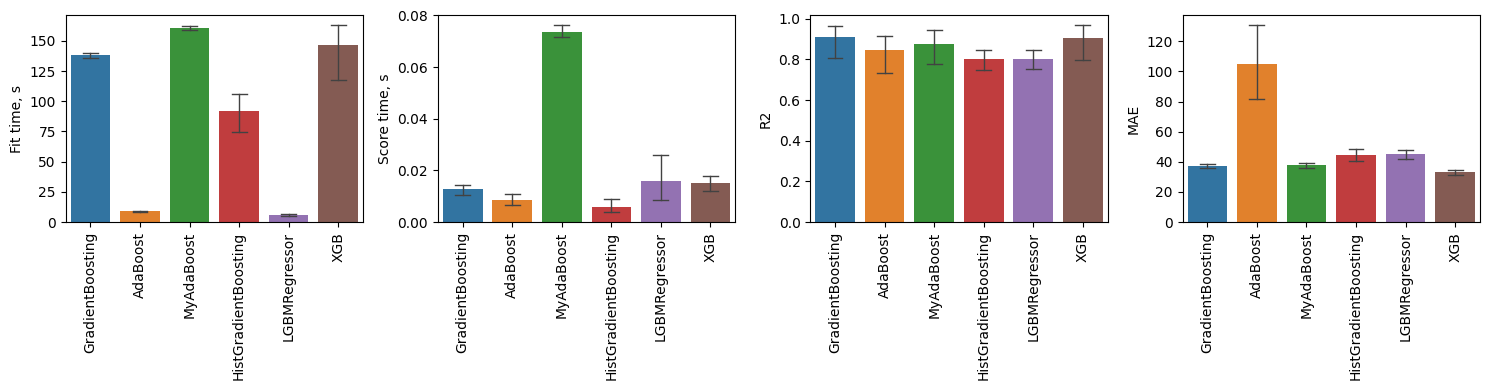

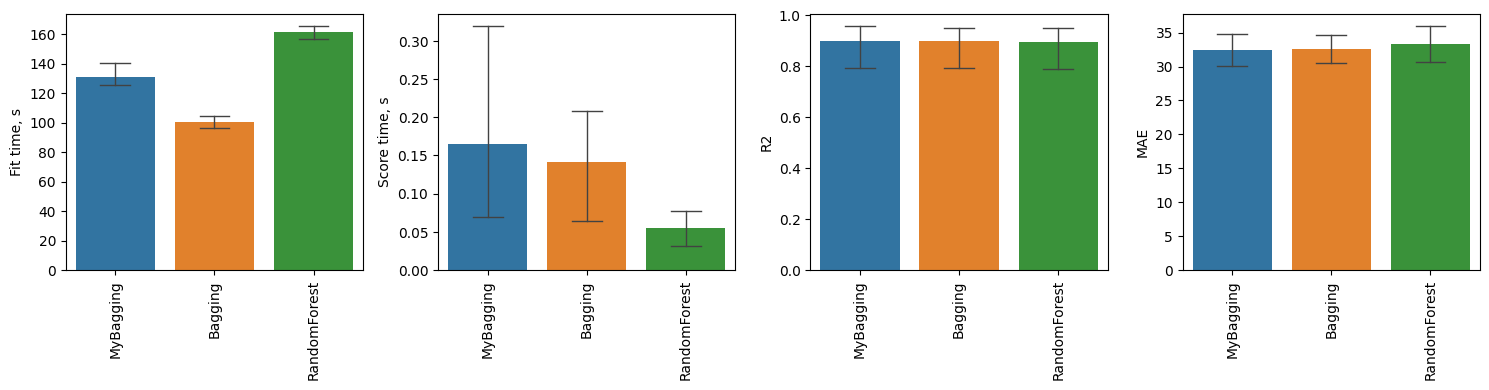

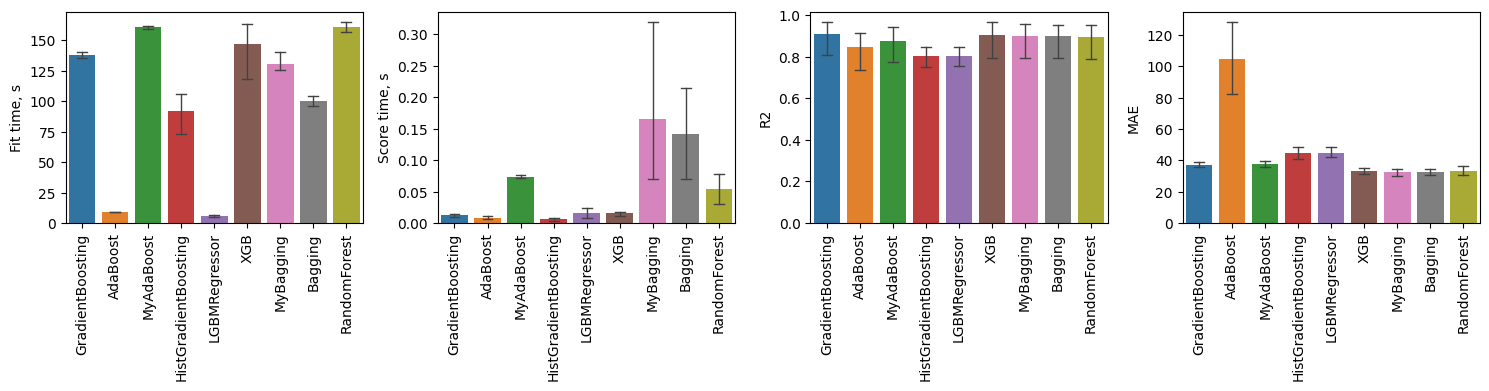

In [59]:
import pathlib

boosting_path = pathlib.Path("boosting.csv")
bagging_path = pathlib.Path("bagging.csv")
all_path = pathlib.Path("all.csv")

add_all_to_comparsion(boosting_models, pathlib.Path("boosting.csv"))
add_all_to_comparsion(bagging_models, pathlib.Path("bagging.csv"))
add_all_to_comparsion(boosting_models + bagging_models, pathlib.Path("all.csv"))

show_comparsion(boosting_path)
show_comparsion(bagging_path)
show_comparsion(all_path)